# AnyGPT for SELFIES-Data Modeling

In this notebook, we find the best GPT architecture for SELFIES-data modeling via
multiobjective hyperparameter optimization with `optuna` and autoregressive
language modeling with `🤗 transformers` and `⚡️ lightning`.

## Environment

If you have already installed dependencies from our __environment.yml__, skip the cell below.

In [1]:
!pip3 install \
    torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu110 \
    pytorch-lightning transformers \
    optuna scikit-learn \
    rdkit-pypi selfies \
    pandas seaborn bertviz plotly \
    --user --quiet

In [2]:
import collections
import functools
import gc
import math
import pathlib
from typing import List, Literal, Optional, Tuple

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import optuna
import seaborn as sns
import selfies as sf
import torch

from rdkit.Chem import MolFromSmiles

from tokenizers import Regex, Tokenizer
from tokenizers.implementations import BaseTokenizer
from tokenizers.models import BPE

from tokenizers.pre_tokenizers import Split
from tokenizers.processors import TemplateProcessing
from tokenizers.trainers import BpeTrainer

from transformers import (DataCollatorForLanguageModeling,
                          GPT2Config, GPT2LMHeadModel,
                          PreTrainedTokenizerFast)

from anygpt import AnyGPTConfig, AnyGPTForCausalLM

Environment settings such as paths to data and logs, some hyperparameters, etc.

In [3]:
class EnvironmentConfig:
    ROOT = pathlib.Path('..')
    DATA_DIR = ROOT / 'data'
    TRAIN_DATA = DATA_DIR / 'pubchem-10m-soft.sf'
    LOG_DIR = ROOT / 'logs'
    TOKENIZERS = LOG_DIR / 'tokenizers'
    OPTIMIZE_HYPERPARAMS = False

    @classmethod
    def create_directories(cls):
        cls.DATA_DIR.mkdir(exist_ok=True)
        cls.LOG_DIR.mkdir(exist_ok=True)
        cls.TOKENIZERS.mkdir(exist_ok=True)

    @classmethod
    def seed_everything(cls):
        pl.seed_everything(1234, workers=True)

    @classmethod
    def set_seaborn_theme(cls):
        sns.set_theme(context='paper', style='ticks', 
                      font='sans serif', font_scale=1.25)

    @classmethod
    def set_tokenizers_parallelism(cls, is_parallel='true'):
        import os
        os.environ['TOKENIZERS_PARALLELISM'] = is_parallel

    @classmethod
    def set_logging_levels(cls):
        from rdkit.RDLogger import DisableLog

        DisableLog('rdApp*')
        optuna.logging.set_verbosity(optuna.logging.INFO)


class MiniBatchConfig:
    batch_size = 256
    model_max_length = 128
    workers = 36
    gpus = 4
    vocab_size = 240

In [4]:
EnvironmentConfig.create_directories()
EnvironmentConfig.seed_everything()
EnvironmentConfig.set_seaborn_theme()
EnvironmentConfig.set_tokenizers_parallelism("true")
EnvironmentConfig.set_logging_levels()

Global seed set to 1234


## Data

Tokenization of SELFIES sequences and BPE segmentation.

In [ ]:
class SFTokenizer(BaseTokenizer):
    Config = collections.namedtuple('Config',
                                    ('pad, bos, eos, unk, eow, '
                                     'pad_id, bos_id, eos_id, unk_id'))
    config = Config('<pad>', '<bos>', '<eos>', '<unk>', '', *range(4))

    def __init__(self, segmenation_model=None, **tokenizer_params):

        segmenation_model = segmenation_model or BPE(
            unk_token=self.config.unk, end_of_word_suffix=self.config.eow)
        self._tokenizer = Tokenizer(segmenation_model)

        pre_tokenizer_re = Regex('(\]\[|\[|\])')  # ][ or [ or ]
        pre_tokenizer = Split(pre_tokenizer_re, 'removed')
        self._tokenizer.pre_tokenizer = pre_tokenizer

        post_processor = TemplateProcessing(
            single=f'{self.config.bos} $A {self.config.eos}',
            special_tokens=[(self.config.bos, self.config.bos_id),
                            (self.config.eos, self.config.eos_id)],
        )
        self._tokenizer.post_processor = post_processor

    @classmethod
    def to_selfies(cls, smiles_sequence, **sf_kwargs):
        return sf.encoder(smiles_sequence, **sf_kwargs)

    @classmethod
    def from_selfies(cls, selfies_sequence_n_spaces, **sf_kwargs):
        selfies_tokens = selfies_sequence_n_spaces.split()
        selfies_sequence = ''.join(
            f'[{token}]' for token in selfies_tokens
        )
        return sf.decoder(selfies_sequence)
        
    def train(self, files,
              vocab_size=MiniBatchConfig.vocab_size, min_frequency=10,
              **bpe_kwargs):
        bpe_trainer = BpeTrainer(
            vocab_size=vocab_size,
            min_frequency=min_frequency,
            special_tokens=[self.config.pad, self.config.bos,
                            self.config.eos, self.config.unk],
            end_of_word_suffix=self.config.eow,
            show_progress=False,
            **bpe_kwargs,
        )
        self._tokenizer.train(files, trainer=bpe_trainer)

    @classmethod
    def get_pretrained(cls, *,
                       tokenizer_object=None, tokenizer_file=None,
                       model_max_length=MiniBatchConfig.model_max_length):
        assert tokenizer_file is not None or tokenizer_object is not None

        if tokenizer_object is not None:
            pretrained_tokenizer = PreTrainedTokenizerFast(
                tokenizer_object=tokenizer_object)
        else:
            pretrained_tokenizer = PreTrainedTokenizerFast(
                tokenizer_file=str(tokenizer_file))

        pretrained_tokenizer.add_special_tokens(dict(zip(
            ['pad_token', 'bos_token', 'eos_token', 'unk_token'],
            [cls.config.pad, cls.config.bos, cls.config.eos, cls.config.unk]
        )))
        pretrained_tokenizer.model_max_length = model_max_length
        pretrained_tokenizer.to_selfies = cls.to_selfies
        pretrained_tokenizer.from_selfies = cls.from_selfies

        return pretrained_tokenizer

Note: You can convert 10M SMILES Pubchem into SELFIES data using our
__selfies-to-smiles.ipynb__.

In [6]:
%%time

tokenizer_file = EnvironmentConfig.TOKENIZERS / 'tokenizer.json'
if not tokenizer_file.exists():
    base_tokenizer = SFTokenizer()
    base_tokenizer.train([str(EnvironmentConfig.TRAIN_DATA)])

    print(f'Vocab size: {base_tokenizer.get_vocab_size()}')

    base_tokenizer.save_model(str(EnvironmentConfig.TOKENIZERS))
    base_tokenizer.save(str(tokenizer_file))

    sample_smi = 'N(=O)C#N'
    sample_sf = base_tokenizer.to_selfies(sample_smi)
    encoded_sample_sf = base_tokenizer.encode(sample_sf)
    print(f'Encoding type: {encoded_sample_sf!r}')
    print(f'Tokens: {encoded_sample_sf.tokens}')
    decoded_sample_sf = base_tokenizer.decode(encoded_sample_sf.ids)
    assert sample_smi == base_tokenizer.from_selfies(decoded_sample_sf)

    hf_tokenizer = base_tokenizer.get_pretrained(tokenizer_object=base_tokenizer)
    assert base_tokenizer.get_vocab() == hf_tokenizer.vocab
else:
    hf_tokenizer = SFTokenizer.get_pretrained(tokenizer_file=tokenizer_file)

    sample_smi = 'N(=O)C#N'
    sample_sf = SFTokenizer.to_selfies(sample_smi)
    encoded_sample_sf = hf_tokenizer(sample_sf)
    print(f'Encoding keys: {encoded_sample_sf.keys()}')
    print(f'Tokens: {encoded_sample_sf.tokens()}')

Encoding keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Tokens: ['<bos>', 'N', '=Branch1', 'C', '=O', 'C', '#N', '<eos>']
CPU times: user 8.18 ms, sys: 2.46 ms, total: 10.6 ms
Wall time: 2.82 ms


SELFIES dataset, dataloader, and lightning datamodule.

In [7]:
class SFDataset(torch.utils.data.Dataset):
    def __init__(self, filename, tokenizer):
        self.tokenizer = tokenizer
        self._data = (
            pathlib.Path(filename)
            .read_text(encoding="ascii")
            .splitlines()
        )

    def __len__(self):
        return len(self._data)

    def __getitem__(self, index):
        encoded_sf = self.tokenizer(
            self._data[index], add_special_tokens=False,
            truncation=True, return_tensors="pt")
        return encoded_sf["input_ids"][0]


dataset = SFDataset(EnvironmentConfig.TRAIN_DATA, hf_tokenizer)
dataset[0]

tensor([15, 25, 60, 74, 15, 61, 15, 61, 15, 61, 65, 66, 15, 61, 15, 61, 15, 61,
        65, 66, 15, 66, 15, 68, 25, 15, 15, 60, 15, 26, 15, 15, 26, 15, 15, 65,
        71])

In [8]:
collate_fn = DataCollatorForLanguageModeling(hf_tokenizer, mlm=False)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=MiniBatchConfig.batch_size,
    shuffle=True, collate_fn=collate_fn, num_workers=MiniBatchConfig.workers)
minibatch = next(iter(dataloader))
print(minibatch.keys())
print(f'Input:\n{minibatch["input_ids"]}')
print(f'Output:\n{minibatch["labels"]}')

dict_keys(['input_ids', 'labels'])
Input:
tensor([[26, 61, 60,  ...,  0,  0,  0],
        [15, 15, 15,  ...,  0,  0,  0],
        [15, 26, 15,  ...,  0,  0,  0],
        ...,
        [15, 15, 67,  ...,  0,  0,  0],
        [15, 15, 67,  ...,  0,  0,  0],
        [15, 26, 15,  ...,  0,  0,  0]])
Output:
tensor([[  26,   61,   60,  ..., -100, -100, -100],
        [  15,   15,   15,  ..., -100, -100, -100],
        [  15,   26,   15,  ..., -100, -100, -100],
        ...,
        [  15,   15,   67,  ..., -100, -100, -100],
        [  15,   15,   67,  ..., -100, -100, -100],
        [  15,   26,   15,  ..., -100, -100, -100]])


In [9]:
class SFDataModule(pl.LightningDataModule):
    def __init__(
        self,
        filename: str,
        tokenizer: PreTrainedTokenizerFast,
        batch_size: int = MiniBatchConfig.batch_size,
        num_workers: int = MiniBatchConfig.workers,
        train_size: float = 0.95,
    ) -> None:
        super().__init__()

        self._filename = filename
        self._tokenizer = tokenizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_size = train_size

    def setup(self, stage=None):
        dataset = SFDataset(self._filename, self._tokenizer)
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            dataset,
            [int(self.train_size * len(dataset)),
             int((1 - self.train_size) * len(dataset))],
            generator=torch.Generator().manual_seed(1234),
        )
        self.collate_fn = DataCollatorForLanguageModeling(self._tokenizer,
                                                          mlm=False)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True,
            collate_fn=self.collate_fn, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False,
            collate_fn=self.collate_fn, num_workers=self.num_workers)


del dataloader, collate_fn, dataset
gc.collect()

datamodule = SFDataModule(EnvironmentConfig.TRAIN_DATA, hf_tokenizer,
                          batch_size=2, num_workers=0)
datamodule.setup()
for dataloader in datamodule.train_dataloader(), datamodule.val_dataloader():
    minibatch = next(iter(dataloader))
    print(minibatch.keys(), len(minibatch), len(dataloader))
    print(minibatch["input_ids"])

del dataloader, datamodule, minibatch
_ = gc.collect()

dict_keys(['input_ids', 'labels']) 2 4750000
tensor([[15, 25, 29, 66, 15, 68, 66, 15, 68, 15, 15, 25, 15, 66, 15, 68, 15, 61,
         15, 61, 60, 65, 26, 15, 15, 61, 65, 67, 77,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [15, 15, 15, 61, 15, 61, 26, 15, 61, 15, 61, 15, 15, 15, 15, 15, 15, 15,
         15, 66, 15, 68, 26, 15, 15, 67, 69, 26, 15, 26, 15, 26, 15, 67, 65, 66,
         15, 26, 15, 26, 15, 60, 65, 15, 26, 15, 60, 15, 26, 15, 60, 15, 26, 15,
         65, 75, 26, 15, 60, 15, 26, 15, 60, 15, 26, 15, 69, 65, 60, 26, 26, 15,
         66, 15, 68, 15, 15, 15, 15, 15, 15, 15, 15, 61, 15, 15, 61, 15, 15, 61,
         15, 15]])
dict_keys(['input_ids', 'labels']) 2 250000
tensor([[15, 15, 60, 74, 15, 61, 15, 61, 15, 61, 65, 66, 25, 15,

Utilities to generate and validate new SELFIES sequences.

In [10]:
def is_valid(
    generated_sf_list: List[str],
    tokenizer: PreTrainedTokenizerFast,
) -> bool:
    try:
        generated_sf_str = tokenizer.from_selfies(generated_sf_list)
        smi = MolFromSmiles(generated_sf_str)
        return True
    except (sf.DecoderError, TypeError):
        return False


def generate(
    model: "AnyGPTLitModelForCausalLM",
    tokenizer: PreTrainedTokenizerFast,
    top_p: float = 0.95,
    repetition_penalty: float = 1.2,
) -> str:
    model.eval()

    selfies_start = torch.tensor([[tokenizer.bos_token_id]], device=model.device)
    generated_ids = model.generate(
        selfies_start,
        max_length=tokenizer.model_max_length,
        do_sample=True,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        pad_token_id=tokenizer.eos_token_id,
    )
    generated_tokens = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_tokens

## AnyGPT

Lightning wrapper for _AnyGPT_ $-$ general architecture of GPT for 1D molecular modeling.
See **anygpt.py** module for implementation details.

In [11]:
class AnyGPTLitModelForCausalLM(pl.LightningModule):
    def __init__(
        self, tokenizer, *,

        # AnyGPTConfig (hyper)parameters:
        #     Embeddings
        vocab_size: int = 240,
        max_position_embeddings: int = MiniBatchConfig.model_max_length,
        add_positional_encoding: bool = True,
        #     Number and type of layers
        num_layers: int = 6,
        architecture_scheme: Tuple[Literal["a", "m", "b"]] = tuple("abbbbm"),
        #     Attention type
        attention_type: Literal["global", "local"] = "local",
        window_size: Optional[int] = 96,
        #     Projections
        num_heads: int = 12,
        hidden_size: int = 32 * 12,
        intermediate_size: Optional[int] = (32 * 12) * 3,
        activation_function: Literal["gelu_new", "silu", "relu"] = "gelu_new",
        #     All three dropouts
        dropout: float = 0.1,
        #     Layer normalization
        layer_norm_position: Literal["pre-ln", "post-ln", "none"] = "pre-ln",
        layer_norm_epsilon: float = 1e-5,

        # *Adam* hyperparameters
        lr: float = 5e-4,
        wd: float = 0.0,
        adam_eps: float = 1e-7,
        adam_betas: float = (0.93, 0.995), 

        # Cosine scheduler hyperparameters
        scheduler_T_max: int = 130_000,
        scheduler_eta_min: float = 1e-8,
        scheduler_frequency: int = 1,

        # Validation
        num_generate: int = 500,
        top_p: float = 0.9,
    ) -> None:
        super().__init__()
        self.save_hyperparameters(ignore=("tokenizer",))

        self.tokenizer = tokenizer

        model_config = AnyGPTConfig(
            vocab_size=vocab_size,
            max_position_embeddings=max_position_embeddings,
            add_positional_encoding=add_positional_encoding,
            num_layers=num_layers,
            architecture_scheme=architecture_scheme,
            attention_type=attention_type,
            window_size=window_size,
            num_heads=num_heads,
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            activation_function=activation_function,
            embed_dropout=dropout,
            attention_dropout=dropout,
            resid_dropout=dropout,
            layer_norm_position=layer_norm_position,
            layer_norm_epsilon=layer_norm_epsilon,
        )
        self.model = AnyGPTForCausalLM(model_config)

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)

        loss = outputs['loss']
        ppl = torch.exp(loss)
        performance = {'loss': loss, 'ppl': ppl}

        self.log('loss', performance['loss'],
                 on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_ppl', performance['ppl'],
                 on_step=True, on_epoch=False, prog_bar=True, logger=True)

        return performance

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)

        val_ppl = torch.exp(outputs["loss"])

        self.log("val_ppl", val_ppl,
                 on_step=True, on_epoch=False, prog_bar=True, logger=True)

        return val_ppl

    def validation_epoch_end(self, steps):
        mean_ppl = torch.stack(steps).mean()

        # TODO: something is unpicklable in this notebook
        # generated = joblib.Parallel(n_jobs=-1)(
        #     joblib.delayed(generate)(self.model, self.tokenizer, self.hparams.top_p)
        #     for _ in range(self.hparams.num_generate)
        # )
        generated = [
            generate(self.model, self.tokenizer, self.hparams.top_p)
            for _ in range(self.hparams.num_generate)
        ]
        uniq_generated = frozenset(generated)
        validity = sum(map(functools.partial(is_valid, tokenizer=self.tokenizer),
                           uniq_generated))
        rac = validity / self.hparams.num_generate

        self.log("rac", rac,
                 on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_ppl", mean_ppl,
                 on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.wd,
            eps=self.hparams.adam_eps,
            betas=self.hparams.adam_betas,
        )
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            eta_min=self.hparams.scheduler_eta_min,
            T_max=self.hparams.scheduler_T_max,
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'step',
                'frequency': self.hparams.scheduler_frequency,
            },
        }


datamodule = SFDataModule(EnvironmentConfig.TRAIN_DATA, hf_tokenizer)
datamodule.setup()
minibatch = next(iter(datamodule.train_dataloader()))

hf_model = AnyGPTForCausalLM(AnyGPTConfig())
model_outputs = hf_model(**minibatch)
print(model_outputs.keys())

del datamodule, minibatch, hf_model, model_outputs
_ = gc.collect()

odict_keys(['loss', 'logits', 'past_key_values'])


Architecture search based on multiobjective hyperparameter optimization.
Objectives are _ration of accepted molecules_ and _perplexity_.
Hyperparameters include _sandwich coefficient_.

In [12]:
def create_optuna_objective(trial):
    num_layers = trial.suggest_int("num_layers", 6, 8)
    sandwich_coef = trial.suggest_int("sandwich_coef", 0, num_layers // 2)
    architecture_scheme = (
        "a" * sandwich_coef
        + "b" * (num_layers - 2 * sandwich_coef)
        + "m" * sandwich_coef
    )

    add_positional_encoding = trial.suggest_categorical("add_pos_enc", [True, False])

    attention_type = trial.suggest_categorical("attn_type", ["global", "local"])
    if attention_type == "local":
        window_size = trial.suggest_int("window_size",
                                        64, MiniBatchConfig.model_max_length, 8)
    else:
        window_size = None

    num_heads = trial.suggest_int("num_heads", 9, 12)
    hidden_size = num_heads * trial.suggest_categorical("h_per_head", (24, 32, 48))
    intermediate_size = hidden_size * trial.suggest_int("h_mlp_mult", 2, 4)

    activation_function = trial.suggest_categorical("act_fn",
                                                    ["gelu_new", "silu", "relu"])

    dropout = trial.suggest_uniform("drop", 0.05, 0.15)

    layer_norm_position = trial.suggest_categorical("ln_pos",
                                                    ["pre-ln", "post-ln", "none"])

    top_p = trial.suggest_uniform("top_p", 0.85, 0.95)

    early_stopping_rac = pl.callbacks.early_stopping.EarlyStopping(
        monitor="rac",
        patience=3,
        min_delta=2e-2,
        check_finite=False,
        stopping_threshold=1.0,
        divergence_threshold=None,
        verbose=False,
        mode="max",
        check_on_train_epoch_end=True,
    )
    early_stopping_val_ppl = pl.callbacks.early_stopping.EarlyStopping(
        monitor="val_ppl",
        patience=2,
        min_delta=1e-2,
        check_finite=True,
        stopping_threshold=1.98,
        divergence_threshold=3.5,
        verbose=False,
        mode="min",
        check_on_train_epoch_end=True,
    )
    lit_model_trainer = pl.Trainer(
        logger=False,
        enable_checkpointing=False,
        strategy="dp",
        callbacks=[early_stopping_rac, early_stopping_val_ppl],
        gpus=MiniBatchConfig.gpus,
        min_epochs=3,
        max_epochs=16,
        limit_train_batches=0.15,
    )
    datamodule = SFDataModule(
        EnvironmentConfig.TRAIN_DATA,
        hf_tokenizer,
        batch_size=MiniBatchConfig.batch_size,
        num_workers=MiniBatchConfig.workers,
    )
    lit_model = AnyGPTLitModelForCausalLM(
        # Fixed hyperparameters
        hf_tokenizer,
        vocab_size=hf_tokenizer.vocab_size,
        max_position_embeddings=MiniBatchConfig.model_max_length,
        # Tunable hyperparameters
        num_layers=num_layers,
        architecture_scheme=tuple(architecture_scheme),
        add_positional_encoding=add_positional_encoding,
        attention_type=attention_type,
        window_size=window_size,
        num_heads=num_heads,
        hidden_size=hidden_size,
        intermediate_size=intermediate_size,
        activation_function=activation_function,
        dropout=dropout,
        layer_norm_position=layer_norm_position,
        top_p=top_p,
        # Handcrafted hyperparameters
        layer_norm_epsilon=3e-6,
        adam_betas=(0.93, 0.994),
        adam_eps=2e-7,
        wd=0.0,
        scheduler_T_max=75_000,
        scheduler_eta_min=1e-8,
        scheduler_frequency=1,
    )
    lit_model_trainer.fit(lit_model, datamodule=datamodule)

    metrics = lit_model_trainer.callback_metrics
    return metrics["val_ppl"].item(), metrics["rac"].item()


if EnvironmentConfig.OPTIMIZE_HYPERPARAMS:
    study_name = "anygpt-multiobj"
    storage_name = f"sqlite:///{study_name}-optuna.db"
    pkl_name = f"{study_name}-optuna.pkl"

    optuna_study = optuna.create_study(
        directions=["minimize", "maximize"],
        load_if_exists=True, study_name=study_name, storage=storage_name)
    optuna_study.optimize(create_optuna_objective, n_trials=40)

    joblib.dump(optuna_study, pkl_name)

Pretraining the best GPT on 10M SELFIES data.

In [ ]:
EnvironmentConfig.set_tokenizers_parallelism("false")

csv_logger = pl.loggers.CSVLogger(
    EnvironmentConfig.LOG_DIR,
    flush_logs_every_n_steps=200,
)
checkpoint_cb = pl.callbacks.ModelCheckpoint(csv_logger.log_dir)
early_stopping_val_ppl = pl.callbacks.early_stopping.EarlyStopping(
    monitor="val_ppl",
    patience=4,
    min_delta=5e-3,
    check_finite=True,
    stopping_threshold=None,
    divergence_threshold=3.0,
    verbose=True,
    mode="min",
    check_on_train_epoch_end=True,
)

lit_model_trainer = pl.Trainer(
    logger=csv_logger,
    callbacks=[checkpoint_cb, early_stopping_val_ppl],
    strategy="dp",
    gpus=MiniBatchConfig.gpus,
    max_epochs=30,
    min_epochs=10,
    val_check_interval=0.4,
    limit_train_batches=0.2,
    log_every_n_steps=200,
    auto_scale_batch_size=False,
    auto_lr_find=False,
)
datamodule = SFDataModule(EnvironmentConfig.TRAIN_DATA, hf_tokenizer,
                          batch_size=MiniBatchConfig.batch_size,
                          num_workers=MiniBatchConfig.workers)
lit_model = AnyGPTLitModelForCausalLM(
    hf_tokenizer,
    vocab_size=MiniBatchConfig.vocab_size,
    max_position_embeddings=MiniBatchConfig.model_max_length,
    add_positional_encoding=True,
    num_layers=7,
    architecture_scheme=tuple("aaabmmm"),
    attention_type="global",
    window_size=None,
    num_heads=11,
    hidden_size=48 * 11,
    intermediate_size=(48 * 11) * 4,
    activation_function="gelu_new",
    dropout=0.1,
    layer_norm_position="none",
    layer_norm_epsilon=1e-5,
    lr=5e-4,
    wd=0.0,
    adam_eps=1e-7,
    adam_betas=(0.93, 0.995),
    scheduler_T_max=150_000,
    scheduler_eta_min=1e-8,
    scheduler_frequency=1,
    top_p=0.94,
)
lit_model_trainer.fit(lit_model, datamodule=datamodule)

In [57]:
log_dir = pathlib.Path(csv_logger.log_dir)
metric_logs = pd.read_csv(log_dir / "metrics.csv")
metric_logs = (
    metric_logs
    .rename({"loss": "cross-entropy", "train_ppl": "perplexity"}, axis=1)
    .dropna(subset="perplexity")
    [["step", "cross-entropy", "perplexity", "epoch"]]
    .astype({"epoch": int})
)
metric_logs.tail(10).style.background_gradient()

,step,cross-entropy,perplexity,epoch
84871,161399,0.639978,1.896440,21
84872,161599,0.673612,1.961309,21
86828,161799,0.735433,2.086386,21
86829,161999,0.635041,1.887099,21
86830,162199,0.684547,1.982873,21
86831,162399,0.696220,2.006155,21
86832,162599,0.696401,2.006518,21
86833,162799,0.672197,1.958535,21
86834,162999,0.694067,2.001841,21
86835,163199,0.644618,1.905260,21


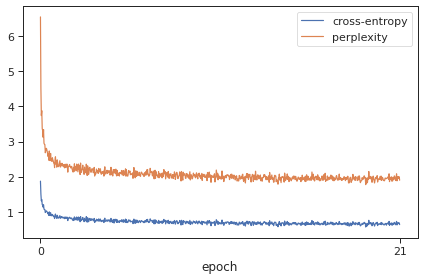

<Figure size 432x288 with 0 Axes>

In [58]:
g = sns.lineplot(x='step', y='value', hue='variable',
                 data=pd.melt(metric_logs.drop(columns='epoch'), ['step']))
g.set_xticks((metric_logs.step.min(), metric_logs.step.max()),
             (metric_logs.epoch.min().astype(int), metric_logs.epoch.max().astype(int)))
g.set_xlabel('epoch')
g.set_ylabel('')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(log_dir / "loss.png")

In [59]:
lit_model.model.config.save_pretrained(log_dir)
lit_model.model.save_pretrained(log_dir)